In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_io as tfio
import shutil

from keras import layers
from keras import models
from IPython import display

from DLHelperFunctions_TFIO import *

import librosa.display
import librosa
import soundfile as sf

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2022-10-23 19:48:44.285188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-23 19:48:45.298646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 19:48:45.314567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 19:48:45.314682: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [2]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
# Set the dataset path
OPUS_DATASET_PATH = './data/mswc_microset/'
WAV_DATASET_PATH = './data/mswc_microset_wav/'
TRIMD_DATASET_PATH = './data/mswc_microset_trimd/'

# Download the dataset
opus_dir = pathlib.Path(OPUS_DATASET_PATH)
wav_dir = pathlib.Path(WAV_DATASET_PATH)
trimd_dir = pathlib.Path(TRIMD_DATASET_PATH)
if not opus_dir.exists():
    tf.keras.utils.get_file(
        'mswc_microset.tar.gz',
        origin="https://storage.googleapis.com/public-datasets-mswc/mswc_microset.tar.gz",
        extract=True,
        cache_dir='.', cache_subdir='data')

In [4]:
# Convert OPUS to WAV & Reformat the directories
wav_ds = os.path.join(wav_dir, 'clips/')

if not os.path.exists(wav_dir):
    os.makedirs(wav_dir)
    if not os.path.exists(wav_ds):
        os.makedirs(wav_ds)

    en_opus_path = os.path.join(opus_dir, 'en/clips/')
    es_opus_path = os.path.join(opus_dir, 'es/clips/')

    opus_to_wav(en_opus_path, wav_ds)
    opus_to_wav(es_opus_path, wav_ds)

In [5]:
# Trim Audio of silence and store
trmd_ds = os.path.join(trimd_dir, 'clips/')

if not os.path.exists(trimd_dir):
    os.makedirs(trimd_dir)
    if not os.path.exists(trmd_ds):
        os.makedirs(trmd_ds)

    for word in os.listdir(wav_ds):
        wav_word_path = os.path.join(wav_ds, word)
        print("Trimming WAVs of \"" + word + "\" class")
        print('++++++++++++++++++++++++++++++++++')
        new_wav_word_path = os.path.join(trmd_ds, word)
        os.makedirs(new_wav_word_path)
        for wav in os.listdir(wav_word_path):
            cur_wav = os.path.join(wav_word_path, wav)
            new_cur_wav = os.path.join(new_wav_word_path, "t_" + wav)
            t_wav, sr = trim_audio(cur_wav)
            #open(os.path.join(trmd_ds, t_name), 'a').close()
            sf.write(new_cur_wav, t_wav, sr, format='wav')
    print('DONE!')

In [6]:
# Decide whther to include entire dataset or reduce size according to number of samples for given classes
sample_threshold = 1300

unused_path = os.path.join(trimd_dir, "unused-clips")

# Iterate "clips" directory
for word in os.listdir(trmd_ds):
    count = 0
    cur_path = os.path.join(trmd_ds, word)
    for wav in os.listdir(cur_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(cur_path, wav)):
            count += 1
    if count <= sample_threshold:
        if not os.path.exists(unused_path):
            os.mkdir(unused_path)
        shutil.move(cur_path, unused_path)

if os.path.exists(unused_path):
    # Iterate "unused-clips" directory
    for word in os.listdir(unused_path):
        count = 0
        cur_path = os.path.join(unused_path, word)
        for wav in os.listdir(cur_path):
            # check if current path is a file
            if os.path.isfile(os.path.join(cur_path, wav)):
                count += 1
        if count >= sample_threshold:
            shutil.move(cur_path, trmd_ds)

In [7]:
# Print the Classification Commands of the Dataset
#words = np.array(tf.io.gfile.listdir(wav_ds))
words = np.array(tf.io.gfile.listdir(trmd_ds))
words = np.sort(words)
print('Words:', words)

Words: ['en-down' 'en-eight' 'en-five' 'en-four' 'en-house' 'en-learn' 'en-left'
 'en-nine' 'en-off' 'en-one' 'en-right' 'en-seven' 'en-six' 'en-stop'
 'en-three' 'en-tree' 'en-two' 'es-ciudad' 'es-cuatro' 'es-dos'
 'es-encuentra' 'es-nombre' 'es-tiempo' 'es-tres' 'es-universidad'
 'es-uno' 'es-vida']


In [8]:
sr = 16000
#sr = 45000

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    #directory=wav_ds,
    directory=trmd_ds,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=sr,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 104554 files belonging to 27 classes.
Using 83644 files for training.
Using 20910 files for validation.

label names: ['en-down' 'en-eight' 'en-five' 'en-four' 'en-house' 'en-learn' 'en-left'
 'en-nine' 'en-off' 'en-one' 'en-right' 'en-seven' 'en-six' 'en-stop'
 'en-three' 'en-tree' 'en-two' 'es-ciudad' 'es-cuatro' 'es-dos'
 'es-encuentra' 'es-nombre' 'es-tiempo' 'es-tres' 'es-universidad'
 'es-uno' 'es-vida']


2022-10-23 19:48:48.230052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-23 19:48:48.230707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 19:48:48.230866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 19:48:48.230968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [9]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [10]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [11]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [12]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


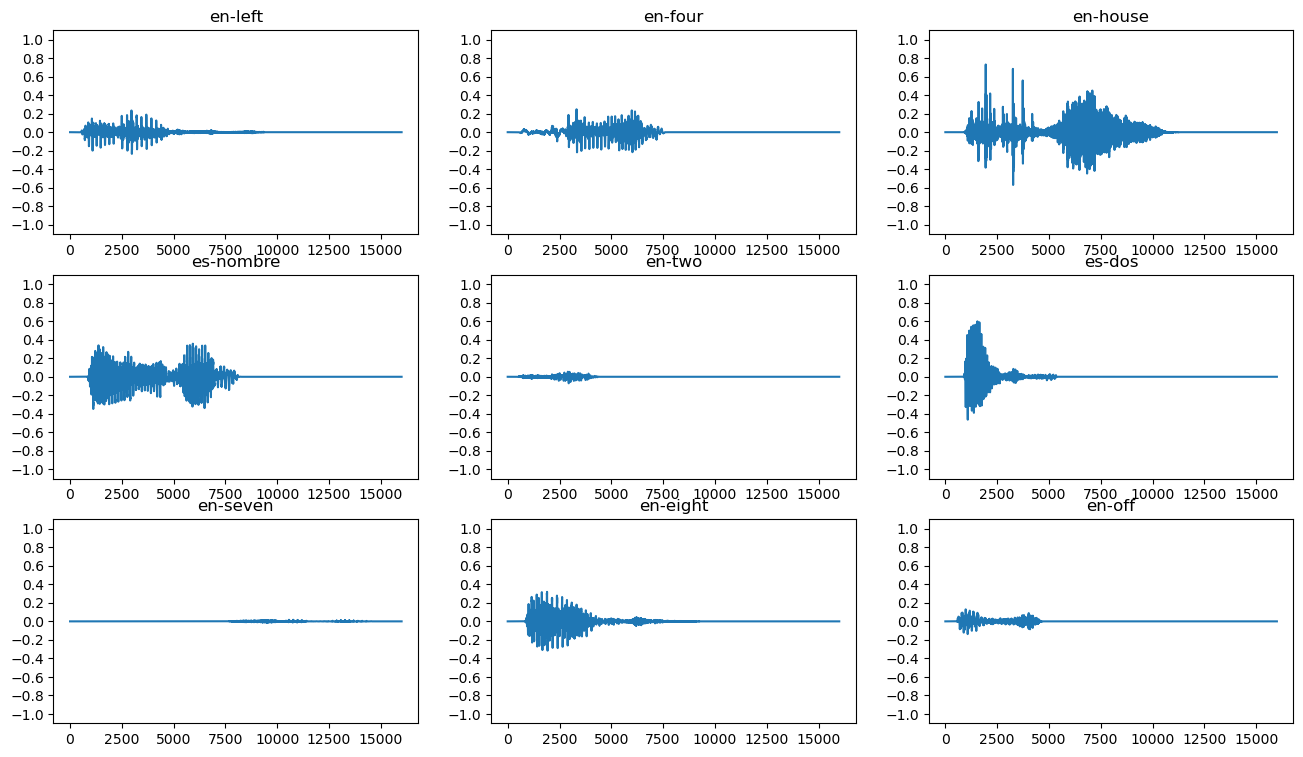

In [13]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [14]:
from DLHelperFunctions_TFIO import *
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=sr))

Label: en-left
Waveform shape: (16000,)
Spectrogram shape: (125, 128, 1)
Audio playback


Label: en-four
Waveform shape: (16000,)
Spectrogram shape: (125, 128, 1)
Audio playback


Label: en-house
Waveform shape: (16000,)
Spectrogram shape: (125, 128, 1)
Audio playback


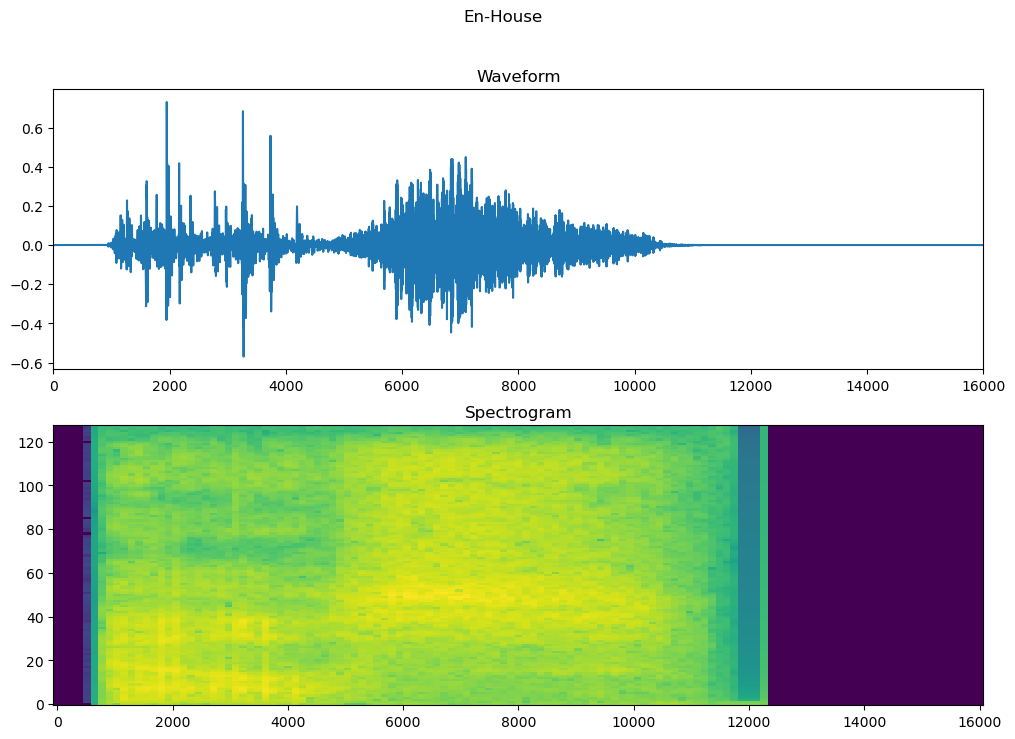

In [15]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, sr])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [16]:
# Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model
train_ds = train_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [17]:
train_spectrogram_ds = make_features_ds(train_ds,sr)
val_spectrogram_ds = make_features_ds(val_ds,sr)
test_spectrogram_ds = make_features_ds(test_ds,sr)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
train_spectrogram_ds.element_spec

(TensorSpec(shape=(None, 125, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

spec_example=example_spectrograms[:,:,:,0:1]
melspec_example=example_spectrograms[:,:,:,1:2]
mfcc_example=example_spectrograms[:,:,:,2:3]

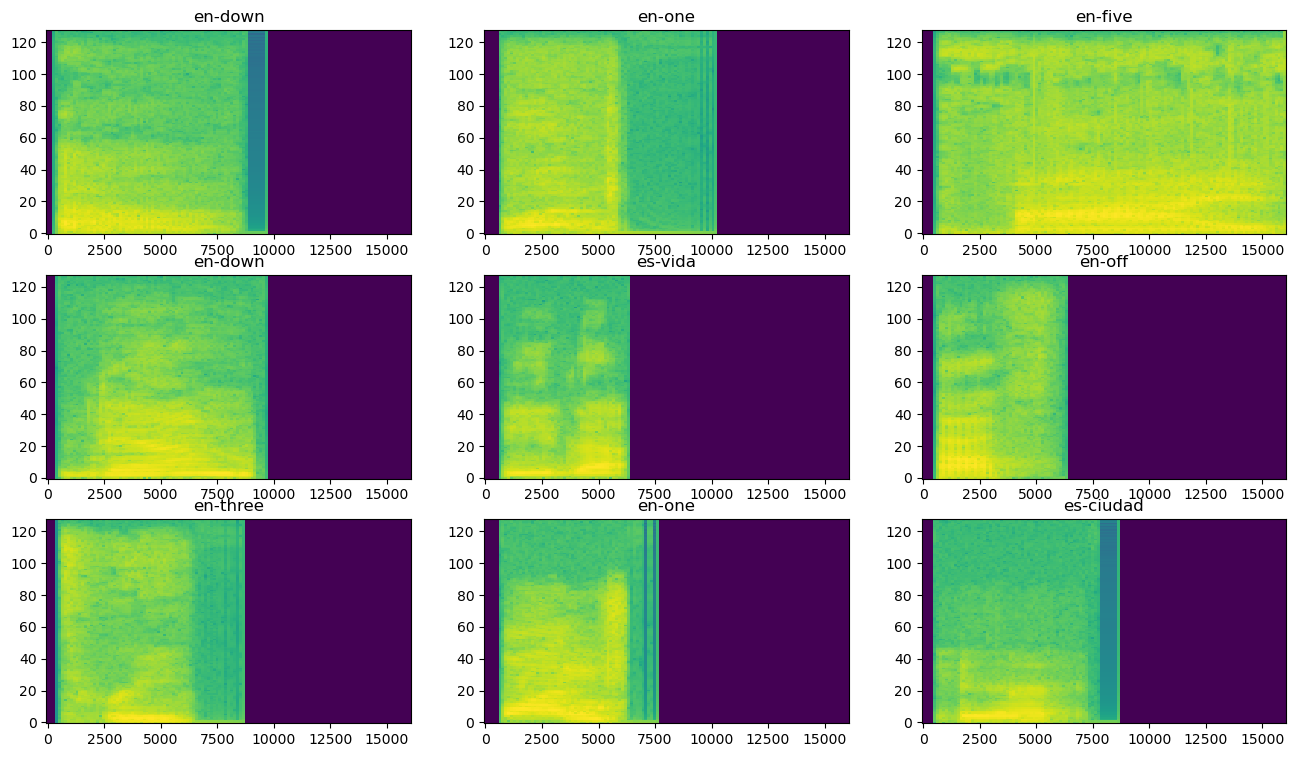

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spec_example[i].numpy(), ax)
    ax.set_title(words[example_spect_labels[i].numpy()])

plt.show()

In [21]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [22]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(words)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (125, 128, 3)


2022-10-23 19:49:02.368103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 803 of 10000
2022-10-23 19:49:08.145404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 3)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [24]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20


2022-10-23 19:49:11.099953: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2022-10-23 19:49:11.463960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2022-10-23 19:49:12.440319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-10-23 19:49:12.441368: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fae488e9ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-10-23 19:49:12.441379: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2022-10-23 19:49:12.443921: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_uti

1307/1307 [==============================] - 10s 6ms/step - loss: 1.2922 - accuracy: 0.6293 - val_loss: 0.6129 - val_accuracy: 0.8211
Epoch 2/20
1307/1307 [==============================] - 5s 4ms/step - loss: 0.7729 - accuracy: 0.7720 - val_loss: 0.4995 - val_accuracy: 0.8559
Epoch 3/20
1307/1307 [==============================] - 5s 4ms/step - loss: 0.6421 - accuracy: 0.8087 - val_loss: 0.4283 - val_accuracy: 0.8745
Epoch 4/20
1307/1307 [==============================] - 5s 4ms/step - loss: 0.5709 - accuracy: 0.8278 - val_loss: 0.3998 - val_accuracy: 0.8838
Epoch 5/20
1307/1307 [==============================] - 5s 4ms/step - loss: 0.5217 - accuracy: 0.8431 - val_loss: 0.3883 - val_accuracy: 0.8851
Epoch 6/20
1307/1307 [==============================] - 5s 4ms/step - loss: 0.4850 - accuracy: 0.8523 - val_loss: 0.3837 - val_accuracy: 0.8844
Epoch 7/20
1307/1307 [==============================] - 5s 4ms/step - loss: 0.4581 - accuracy: 0.8597 - val_loss: 0.3635 - val_accuracy: 0.8912
Ep

Text(0, 0.5, 'Accuracy [%]')

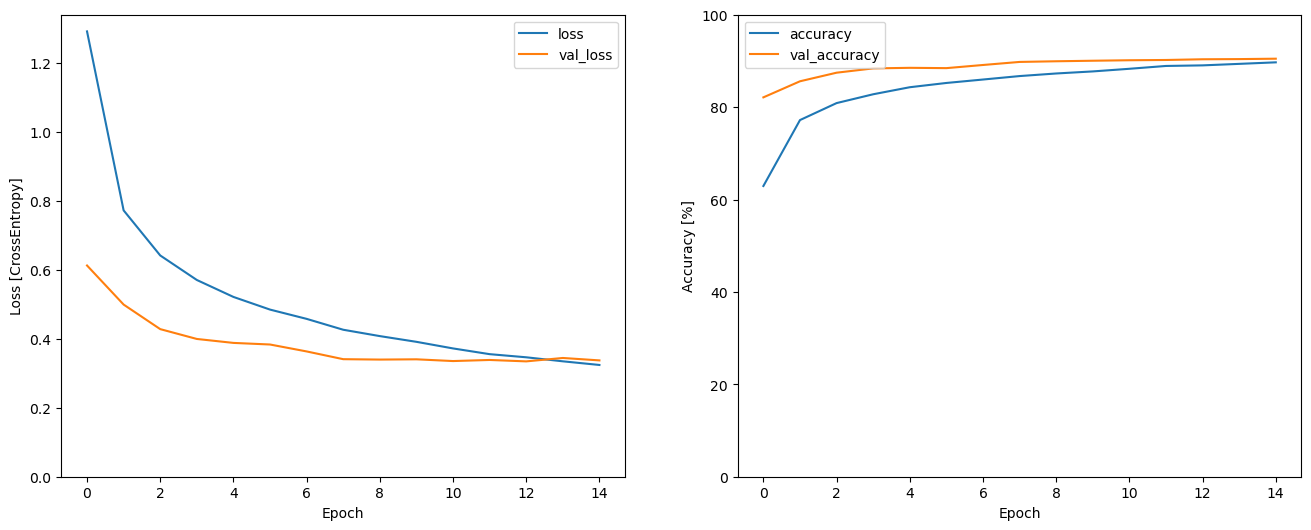

In [25]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [26]:
model.evaluate(test_spectrogram_ds, return_dict=True)

164/164 [==============================] - 3s 14ms/step - loss: 0.3335 - accuracy: 0.9007


{'loss': 0.3335091769695282, 'accuracy': 0.9007444381713867}

In [27]:
y_pred = model.predict(test_spectrogram_ds)

164/164 [==============================] - 0s 2ms/step


In [28]:
y_pred = tf.argmax(y_pred, axis=1)

In [29]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

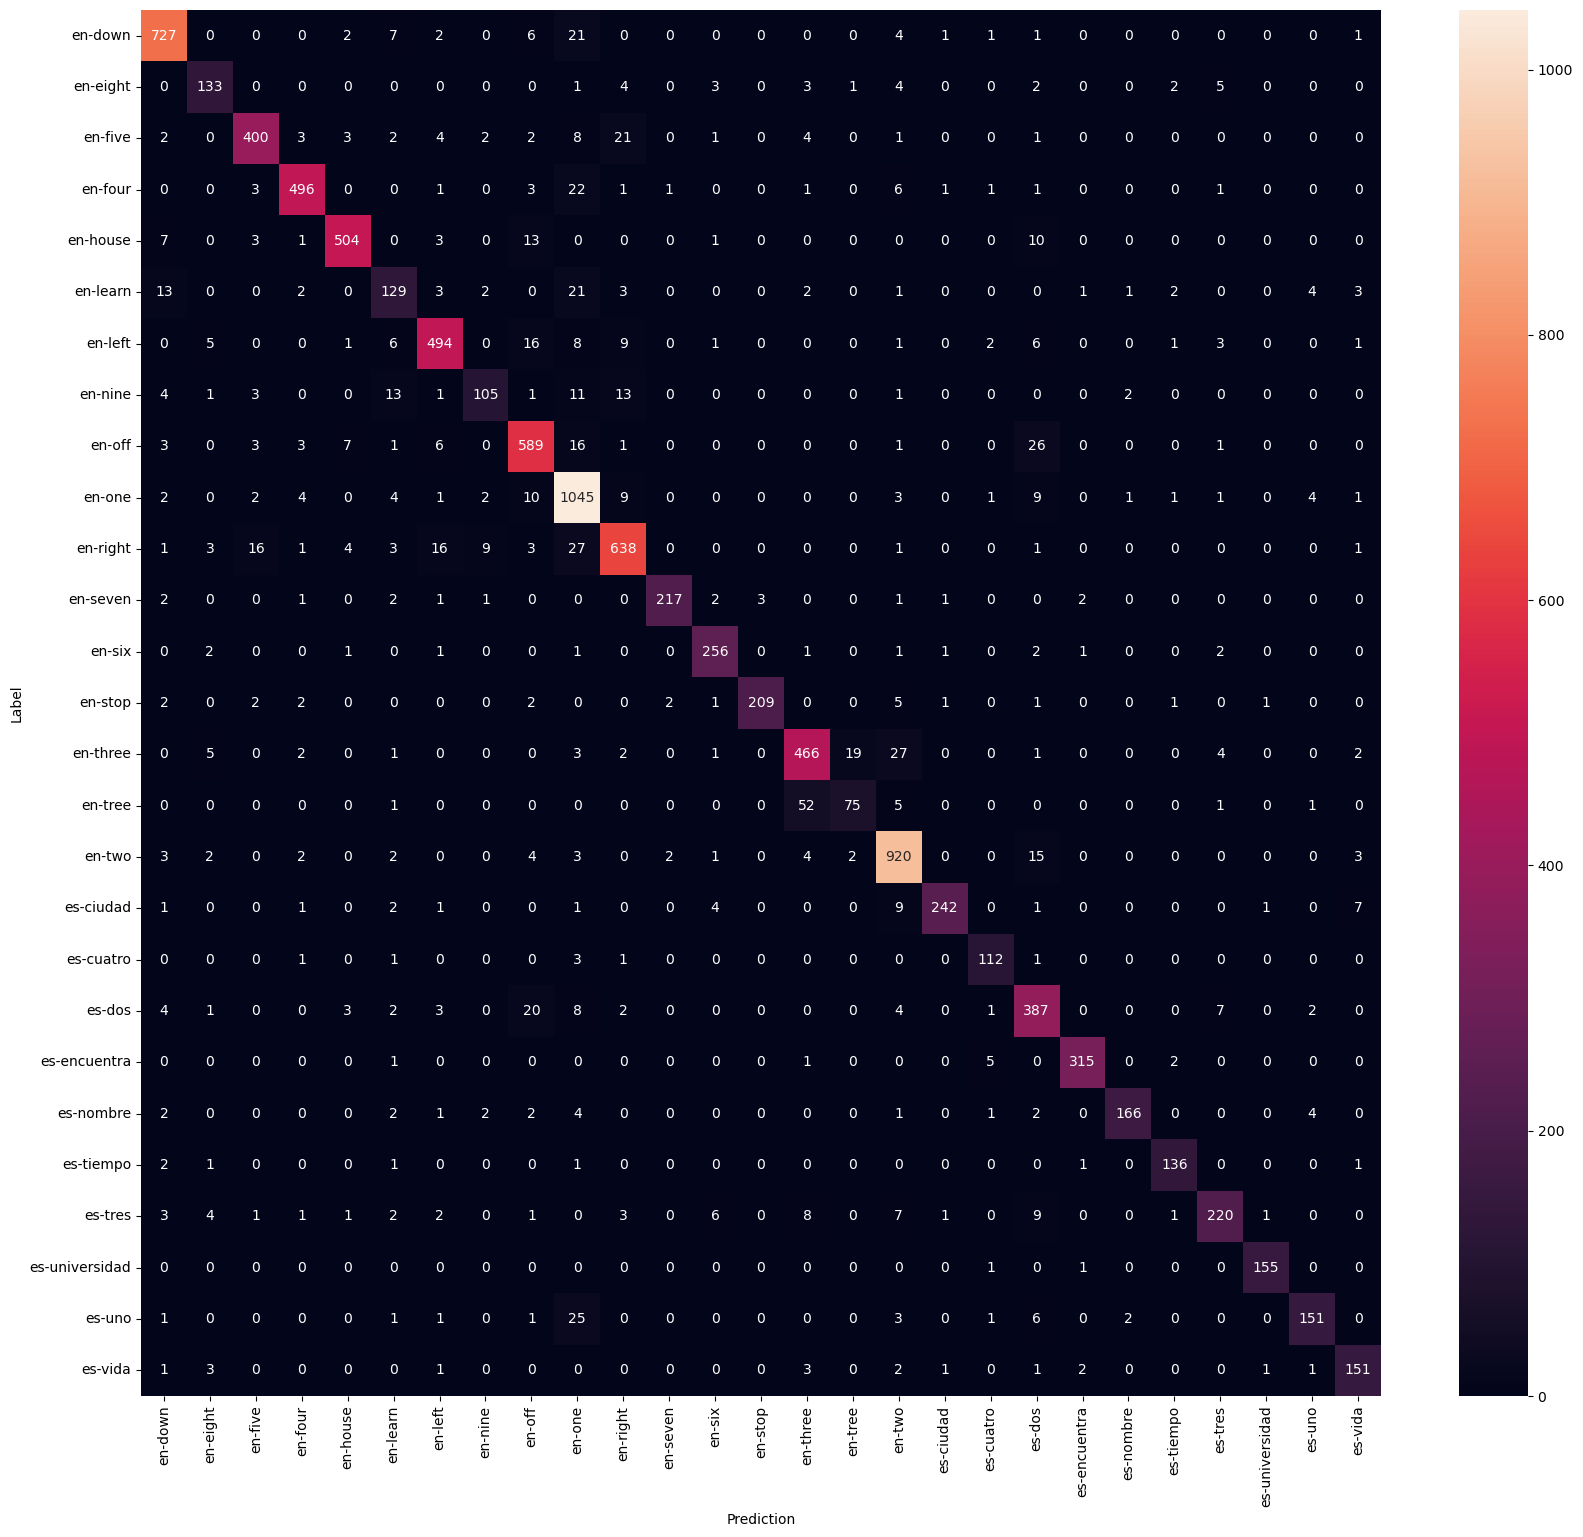

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 18))
sns.heatmap(confusion_mtx,
            xticklabels=words,
            yticklabels=words,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

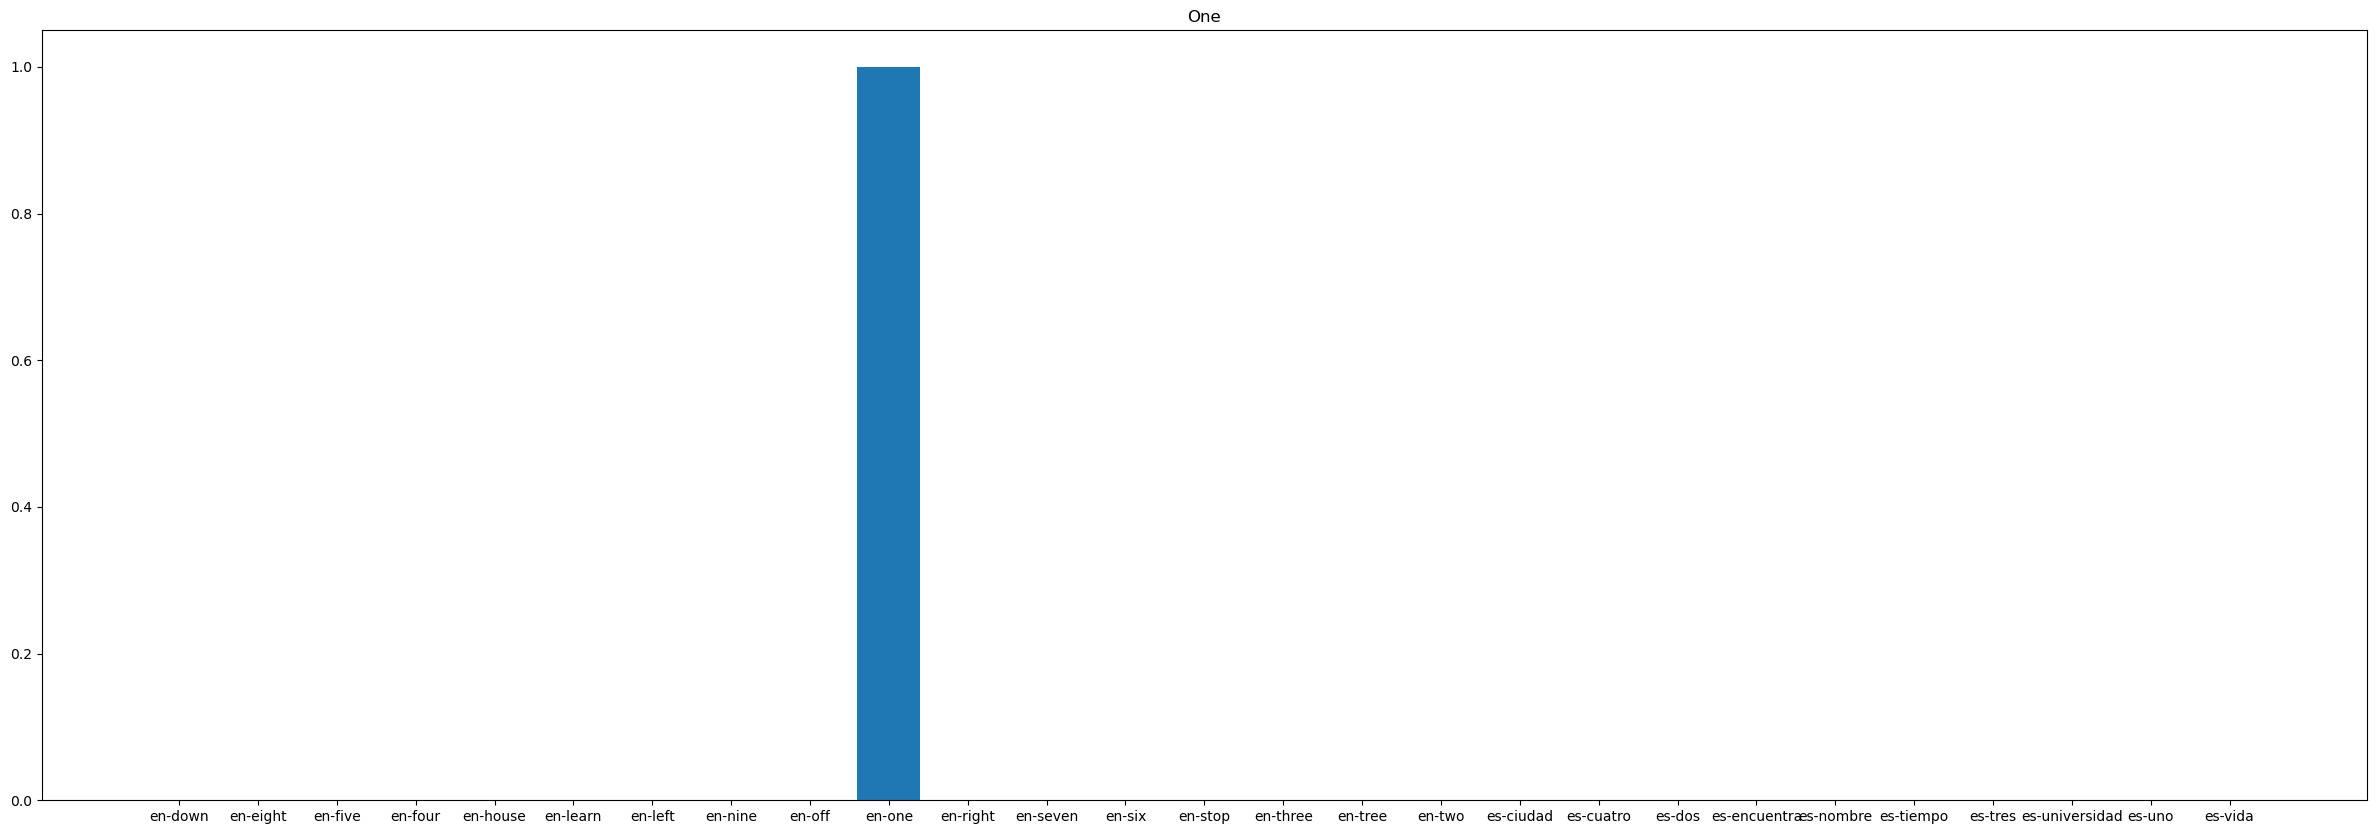

In [31]:
a, _ = trim_audio('inference_samples/one.wav')
x = 'inference_samples/one_trmd.wav'
sf.write(x, a, sr, format='wav')
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=sr)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_features(x,sr)
x = x[tf.newaxis,...]

prediction = model(x)
plt.figure(figsize=(30,10))
plt.bar(words, tf.nn.softmax(prediction[0]))
plt.title('One')
plt.show()


display.display(display.Audio(waveform, rate=20000))

In [32]:
# Save model in "./saved"
model.save("saved")

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


In [33]:
en_dict = {'en-backward': 'hacia atrás', 
           'bed' : 'cama',
           'bird' : 'pájaro',
           'down' : 'abajo',
           'eight' : 'ocho',
           'five' : 'cinco',
           'follow' : 'seguir',
           'forward' : 'hacia adelante',
           'four' : 'cuatro',
           'house' : 'casa',
           'learn' : 'aprender',
           'left' : 'izquierda',
           'marvin' : 'marvin',
           'nine' : 'nueve',
           'off' : 'apagado',
           'one' : 'uno',
           'right' : 'derecho',
           'seven' : 'siete',
           'sheila' : 'sheila',
           'six' : "seis",
           'stop' : 'parar',
           'three' : 'tres',
           'tree' : 'árbol',
           'two' : 'dos',
           'visual' : 'visual',
           'wow' : 'guau',
           'yes' : 'sí',
           'zero' : 'cero'
}

es_dict = {
           'canción' : "song",
           'cero' : "zero",
           'cinco' : "five",
           'ciudad' : "city",
           'color' : 'color',
           'cuatro' : 'four',
           'dos' : 'two',
           'encuentra' : 'find',
           'juego' : 'game',
           'nombre' : 'name',
           'nueve' : 'nine',
           'número' : 'number',
           'ocho' : 'ocho',
           'seis' : 'six',
           'siete' : 'seven',
           'tiempo' : 'time',
           'tres' : 'three',
           'universidad' : 'university',
           'uno' : 'one',
           'vida' : 'life'
}

lang_dict = {
                'en' : 'English',
                'es' : "Spanish"
}

pred_ind = np.array(tf.argmax(prediction, axis=1))
probs = words[pred_ind]
probs = probs[0].split('-')

if probs[0] == 'en':
    translation = en_dict.get(probs[1])
elif probs[0] == 'es':
    translation = es_dict.get(probs[1])
else:
    print('ERROR: UNKNOWN LANGUAGE CODE')

lang = lang_dict[probs[0]]

print("Detected Language: " + lang + "\n\n")
print("Detected Word: " + probs[1] + "\n\n")
print("Translation: " + translation)

Detected Language: English


Detected Word: one


Translation: uno
